## Distribution sampling

Current method: each param of a Dirichlet is one of the entries in the training CM, each param of multinomial is sampled from that Dirichlet (Caelen). 

Use this to simulate n CMs based off a training CM, and find 1, the average estimated counts/distances from each simulated CM and 2, the variance of each estimate

To use:

1. Get training confusion matrix as df, ground truth modes as rows, sensed modes as columns
2. Get validation data as dictionary, keys are modes, values are the predicted counts/distances
2. Run find_counts(trainingCM, data) or find_distances(trainingCM, data, OS)

All the necessary cells are under "RUN THESE!", all examples of using the functions under "EXAMPLES" (very messy)

## RUN THESE!

Sampling and probability fcns needed for both counts and distances

In [9]:
# sampling and probability calculation fcns which you need to do for both counts and distances.

import pandas as pd
import numpy as np
from numpy.random import default_rng

'''
Sample a CM (as a DF) and create n # of CMs based on it.
input: a CM to sample, number of times to sample
output: a list of n CMs
'''
def sampling(samplingCM, n):
    # dirichlet sampling
    v = [] # from the CM, going left to right by row
    for row in samplingCM.index:
        for col in samplingCM.columns:
            v.append(samplingCM.loc[row][col])
    a = np.ones(samplingCM.size)

    rng = default_rng()
    dirichlet_samples = rng.dirichlet((v+a), n)

    # multinomial sampling
    multinomial_samples = []
    n_trips = 0
    for col in samplingCM:
        n_trips += samplingCM[col].sum()

    for params in dirichlet_samples:
        s = rng.multinomial(n_trips, params)
        multinomial_samples.append(s)

    # put each of these into their own CM, same dimensions as samplingCM (do row by row)
    output_CMs = []
    for samples in multinomial_samples:
        samples2D = np.reshape(samples, (len(samplingCM.index), len(samplingCM.columns)))
        outputCM = pd.DataFrame(samples2D, columns = samplingCM.columns, index = samplingCM.index)
        output_CMs.append(outputCM)
    return output_CMs

'''
Finding P(actual|sensed) by dividing each cell by column sum, for a list of DFs
input: list of DFs of values
output: list of DF of P(actual|sensed)
'''
def actual_given_sensed_CM(list_of_value_CMs):
    actual_given_sensed = []
    for cm in list_of_value_CMs:
        probs = cm.div(cm.sum(axis=0), axis=1)
        actual_given_sensed.append(probs)
    return actual_given_sensed


Distance estimation function

In [10]:
# distance estimation and variance calculation fcn. very similar to the count fcn.

import pandas as pd
import numpy as np

'''
Finding estimated values and variances FOR DISTANCES.
input: 
    predicted_distances: a dictionary {"mode1": # of trips predicted in mode1...}
    actual_given_sensed: list of DFs, which have probabilities in each cell
    os: which OS we're using, either "ios" or "android"
output: a single estimated distance for each mode, and a single estimated variance for each mode. 
    (prints some other interesting stuff out too)
'''
def distance_estimate(predicted_distances, actual_given_sensed, os):
    os_unit_info = pd.read_csv(r'unit_distance_MCS.csv')

    # adjusting using os unit info
    adjusted_predicted_distances = {}
    for mode in predicted_distances.index:
        adjusted_predicted_distances[mode] = predicted_distances[mode] * os_unit_info[os][0]

    # find expected counts based on each actual_given_sensed CM and predicted counts
    expected_counts = [] #list of dfs (one df per cm)
    for df in actual_given_sensed:
        expected_value = df.mul(adjusted_predicted_distances, axis = 'columns') # multiply row by row
        expected_value = expected_value.sum(axis='columns') # sum of each row
        expected_counts.append(expected_value)
    
    # average expected values: concat dfs and find mean
    all_expected = pd.concat(expected_counts, axis='columns')
    average_ev = all_expected.mean(axis='columns')

    #VARIANCES
    df_list = []
    for df in actual_given_sensed:
        df_list.append(df.to_numpy())

    # variance of each cell in prob CMs    
    cell_variance = np.square(pd.DataFrame(np.dstack((df_list)).std(axis=2), columns = actual_given_sensed[0].columns, index = actual_given_sensed[0].index)) 
    
    # multiply each row of cell variances by the row of L_i^2
    adjusted_predicted_distances = pd.DataFrame([adjusted_predicted_distances])
    n_squared = np.square(adjusted_predicted_distances) #row of L^2s
    variance1 = cell_variance.mul(n_squared.values, axis = 'columns') # E(L_mode)^2 V(p)
    
    # extra variance term since distance has its own uncertainty
    avg_actual_given_sensed = pd.DataFrame(np.dstack((df_list)).mean(axis=2), columns = actual_given_sensed[0].columns, index = actual_given_sensed[0].index)
    dist_variance = np.square(pd.Series(predicted_distances)) * os_unit_info[os][1] # row of L_i^2s
    variance2 = dist_variance.mul(np.square(avg_actual_given_sensed)) # E(p)^2*V(L_mode)]

    # sum up rows
    variance = variance1.add(variance2)
    variance = variance.sum(axis='columns')

    # diff = pd.Series(average_ev).T.subtract(pd.Series(predicted_distances)).T #expected value - actual value

    # count_results = pd.DataFrame({"EV": average_ev, 
    #                             "actual": pd.Series(predicted_distances), 
    #                             "diff":diff,
    #                             "variance":variance,
    #                             "stdev from actual":diff.div(np.sqrt(variance), axis='rows')}) #diff/sqrt(variance)
    # print(count_results)
    # print("\nPredicted:\n", predicted_distances.T)
    return (average_ev, variance)


Count estimation function

In [4]:
# count estimate and variance calculation fcn.

import pandas as pd
import numpy as np

'''
Finding estimated values and variances FOR COUNTS.
input:
    predicted_counts: a dictionary {"mode1": # of trips predicted in mode1...}
    actual_given_sensed: list of DFs, which have probabilities in each cell
output: a single estimated count for each mode, and a single estimated variance for each mode count. 
    (prints some other interesting stuff out too)
'''
def count_estimate(predicted_counts, actual_given_sensed):
    # find expected counts based on each actual_given_sensed CM and predicted counts
    expected_counts = [] #list of dfs (one df per cm)
    for df in actual_given_sensed:
        expected_value = df.mul(pd.Series(predicted_counts), axis = 'columns') # multiply row by row
        expected_value = expected_value.sum(axis='columns') # sum of each row
        expected_counts.append(expected_value)

    # average expected values: concat dfs and find mean
    all_expected = pd.concat(expected_counts, axis='columns')
    average_ev = all_expected.mean(axis='columns')

    #VARIANCES
    # variance of each cell
    df_list = []
    for df in actual_given_sensed:
        df_list.append(df.to_numpy())
    cell_variance = np.square(pd.DataFrame(np.dstack((df_list)).std(axis=2), columns = actual_given_sensed[0].columns, index = actual_given_sensed[0].index)) 

    # multiply each row of cell variances by  the row of n_i^2
    predicted_counts = pd.DataFrame([predicted_counts])
    n_squared = np.square(predicted_counts) #row of n^2s
    n2_times_var = cell_variance.mul(n_squared.values, axis = 'columns')

    # sum up rows
    variance = n2_times_var.sum(axis='columns')

    # diff = pd.Series(average_ev).T.subtract(predicted_counts).T #expected value - actual value

    # count_results = pd.DataFrame({"EV": average_ev, 
    #                             "actual": (predicted_counts),
                                # "diff":diff,
                                # "stdev from actual":diff.div(np.sqrt(variance), axis='rows')}) #diff/sqrt(variance)
    # print(count_results)
    # print("\nPredicted:\n", predicted_counts.T)

    return (average_ev, variance)

In [5]:
# find counts. Returns a tuple, (dataframe of estimated counts for each mode, dataframe of variances for each mode count)
def find_counts(trainingCM, data):
    countSamples = sampling(trainingCM, 2000) # you can change 2000 to anything!
    countProbs = actual_given_sensed_CM(countSamples)
    countEstimates = count_estimate(data, countProbs)
    return countEstimates

In [6]:
# find distances. Returns a tuple, (dataframe of estimated distances for each mode, dataframe of variances for each distance)
def find_distances(trainingCM, data, os):
    distanceSamples = sampling(trainingCM, 2000) # you can change 2000 to anything!
    distanceProbs = actual_given_sensed_CM(distanceSamples)
    distanceEstimates = distance_estimate(data, distanceProbs, os)
    return distanceEstimates

## EXAMPLES

CM-creation funtions

In [11]:
# functions for taking raw CBC CO trip data to cleaned CMs
# add the fcns here to confusion_matrix_handling.py!!!

import pandas as pd
import numpy as np
import helper_functions as helper
import confusion_matrix_handling as cm_handling

'''
Loop through a DF of trips and tally up label pairs. Pairs are made of 'primary_mode' and 'mode_confirm' labels.
    (primary_mode column comes from get_primary_modes fcn in helper_functions.py)
    Will match either by counts or by distance.
Input: DF of raw trip data (data with a buncha extra info, one row per trip)
Output: CM of pairs and their counts or distances (as a DF).
'''
def pair_matching(df, by_distances=False):
    # make columns of sensed labels (primary_mode)
    columns = {} # looks like {sensed_label: {user_label: count, user_label: count...}}
    value = 1 # default is by counts, where we add one each time
    for index, row in df.iterrows():
        if by_distances: # if set to true, instead of adding one for each pair, we add distances
            value = row['distance']
        if row['primary_mode'] not in columns: # if sensed label not added as column yet
            columns[row['primary_mode']] = {} # make column
            columns[row['primary_mode']][row['mode_confirm']] = value
        elif row['mode_confirm'] not in columns[row['primary_mode']]: #if user label not in sensed label column
            columns[row['primary_mode']][row['mode_confirm']] = value
        else: # else [sensed label, user label] pair already there
            columns[row['primary_mode']][row['mode_confirm']] += value
        
    pairs = pd.DataFrame(columns)
    return pairs

'''
Consolidate user labels (row labels, aka DF index labels) of a user_label, sensed_label CM that are basically the same by using some mode map dictionary.
    If rows have the same label after mapping, they're combined by addition.
    If rows have no user label, they're dropped.
    If remove_unknown is true, unknown labels are also dropped.
Input: DF, mapping dictionary (with the form {user label: standardized label})
Output: DF with new index labels
'''
def map_labels(df, map, remove_unknown=True):
    # do mapping
    renamed_pairs = df.rename(index=map)
    consolidated_pairs = renamed_pairs.groupby(level=0).aggregate(['sum'])

    # remove the annoying "sum" part of the label that appears after aggregate
    consolidated_pairs.columns=consolidated_pairs.columns.droplevel(1)
    
    # remove rows where user label is not in map if set
    if remove_unknown:
        for index, data in consolidated_pairs.iterrows():
            if index not in map:
                consolidated_pairs = consolidated_pairs.drop(labels = [index], axis = 0)
    return consolidated_pairs

'''
Add missing rows or columns to a DF according to a list of other DFs. New rows/cols filled with all zeroes.
Input: list of model DFs, DF to modify
Output: DF with filled in rows and columns
'''
def fill_in(inputCMs, badCM):
    wanted_columns = []
    wanted_rows = []
    for inputCM in inputCMs:
        for col in inputCM.columns:
            if col not in wanted_columns:
                wanted_columns.append(col)
        for row in inputCM.index:
            if row not in wanted_rows:
                wanted_rows.append(row)
                
    for col in wanted_columns:
        if col not in badCM.columns:
            badCM[col] = np.zeros(len(badCM.index))
    for row in wanted_rows:
        if row not in badCM.index:
            badCM.loc[row] = np.zeros(len(badCM.columns))
    return badCM

Plot results of count_estimate or distance_estimate, compared against actual counts/distances

In [87]:
import matplotlib.pyplot as plt

def plot_results(estimated_values, actual_values, variances, y_lab, title):
    n=len(estimated_values.index)
    x_range = np.arange(n)
    width = 0.5

    plt.bar(x_range, estimated_values, yerr = variances, color = 'tab:orange', width = width, label = 'expected', capsize= 5)
    plt.bar(x_range + width, actual_values, color = 'tab:blue', width = width, label = 'actual', capsize= 5)

    plt.xlabel("Mode",fontsize = 14)
    plt.ylabel(y_lab,fontsize = 14)
    plt.title(title,fontsize = 15)
    
    plt.xticks(x_range + width/2, estimated_values.index, fontsize= 12)
    plt.legend(prop={'size': 12})
    plt.rcParams["figure.figsize"] = (3*n,8)
    plt.show()


Putting CanBikeCO trip data into CMs

In [12]:
# get data
# make df for each half of data (use one half for distribution sampling, the other half for the estimating part)
'''
Split data and get two nice DFs
'''
df_EI = pd.read_csv(r'Public_Dashboard/auxiliary_files/energy_intensity.csv')
energy_dict = cm_handling.get_energy_dict(df_EI, units='MWH')
from confusion_matrix_handling import MODE_MAPPING_DICT

# get result from running store_expanded_labeled_trips.ipynb
%store -r expanded_labeled_trips 
expanded_labeled_trips = helper.get_primary_modes(expanded_labeled_trips[expanded_labeled_trips.section_modes.notna()], energy_dict, MODE_MAPPING_DICT)

# split in half.
from sklearn.utils import shuffle
shuffled_trips = shuffle(expanded_labeled_trips)
shuffled_trips = helper.drop_unwanted_trips(shuffled_trips, drop_not_a_trip=True)
samplingCM = shuffled_trips.iloc[0:int(len(expanded_labeled_trips.index)/2)]
testingCM = shuffled_trips.iloc[int(len(expanded_labeled_trips.index)/2):]

split_by_os = True 

if split_by_os: # for distances
    samplingCMiOS = samplingCM.loc[samplingCM['os'] == "ios"]
    samplingCMandroid = samplingCM.loc[samplingCM['os'] == "android"]
    testingCMiOS = testingCM.loc[testingCM['os'] == "ios"]
    testingCMandroid = testingCM.loc[testingCM['os'] == "android"]

    samplingCMiOS = pair_matching(samplingCMiOS, by_distances=True)
    samplingCMandroid = pair_matching(samplingCMandroid, by_distances=True)
    testingCMiOS = pair_matching(testingCMiOS, by_distances=True)
    testingCMandroid = pair_matching(testingCMandroid, by_distances=True)

    samplingCMiOS = map_labels(samplingCMiOS, MODE_MAPPING_DICT)
    samplingCMandroid = map_labels(samplingCMandroid, MODE_MAPPING_DICT)
    testingCMiOS = map_labels(testingCMiOS, MODE_MAPPING_DICT)
    testingCMandroid = map_labels(testingCMandroid, MODE_MAPPING_DICT)

    # convert from meters to miles
    METERS_TO_MILES = 0.000621371 # 1 meter = 0.000621371 miles
    samplingCMiOS = samplingCMiOS * METERS_TO_MILES
    samplingCMandroid = samplingCMandroid * METERS_TO_MILES
    testingCMiOS = testingCMiOS * METERS_TO_MILES
    testingCMandroid = testingCMandroid * METERS_TO_MILES

    testingCMiOS = fill_in([samplingCMiOS, samplingCMandroid, testingCMandroid], testingCMiOS)
    testingCMandroid = fill_in([testingCMiOS], testingCMandroid)
    samplingCMiOS = fill_in([testingCMiOS], samplingCMiOS)
    samplingCMandroid = fill_in([testingCMiOS], samplingCMandroid)
    
    samplingCMiOS = samplingCMiOS.sort_index()
    samplingCMandroid = samplingCMandroid.sort_index()
    testingCMiOS = testingCMiOS.sort_index()
    testingCMandroid = testingCMandroid.sort_index()

    print(samplingCMiOS)
    print(samplingCMandroid)
    print(testingCMiOS)
    print(testingCMandroid)

elif not split_by_os: # for counts
    # clean up
    samplingCM = pair_matching(samplingCM, by_distances=False)
    samplingCM = map_labels(samplingCM, MODE_MAPPING_DICT)
    
    testingCM = pair_matching(testingCM, by_distances=False)
    testingCM = map_labels(testingCM, MODE_MAPPING_DICT)

    samplingCM = fill_in([testingCM], samplingCM)
    testingCM = fill_in([samplingCM], testingCM)

    # also removing the no_sensed and air_or_hsr sensed labels since they don't have a corresp match in the standardized user labels
    samplingCM = samplingCM.drop(labels=["air_or_hsr", "no_sensed"], axis=1)
    testingCM = testingCM.drop(labels=["air_or_hsr", "no_sensed"], axis=1)

    # making rows and columns the same order
    testingCM = testingCM.loc[:, samplingCM.columns]
    testingCM = testingCM.sort_index()
    samplingCM = samplingCM.sort_index()

    print(samplingCM)
    print(testingCM)

# this takes around 20s for the entire all_ceo dataset

Dropped 93 trips with no sensed sections.
Dropping user labeled AIR trips and trips with no OS.
Also dropping trips labeled as not a trip and trips with mode_confirm of nan.
                        bicycling           car      walking   no_sensed  \
Bikeshare               39.996983     11.453476    12.839720    0.211578   
Bus                    282.619886   1902.863071   589.731783   60.277569   
E-car, drove alone       0.000000      0.000000     4.050190    0.000000   
Free Shuttle             0.000000     75.941503     5.088761    0.000000   
Gas Car, drove alone   716.241355  27334.663854  2901.369599  889.007425   
Gas Car, with others  1440.085365  50274.110570  5168.445077  707.353528   
Pilot ebike           7261.101827   9514.091769  3349.327300  611.809014   
Regular Bike          1261.208726    557.333920   525.785967   76.955826   
Scooter share            0.680371      3.842482     5.779186    0.000000   
Skate board              0.000000     99.021130     0.000000    0.

In [55]:
predicted_distances = testingCMandroid.sum(axis=0)
find_distances(samplingCMandroid, predicted_distances, "android")

walking        8516.187595
car           80802.792877
bicycling      7614.808000
bus             374.239010
no_sensed      4920.651546
train           810.268706
air_or_hsr     3692.395252
subway          175.207894
dtype: float64
walking
car
bicycling
bus
no_sensed
train
air_or_hsr
subway


(Bikeshare                  98.355018
 Bus                      4941.308390
 E-car, drove alone          7.711472
 Free Shuttle              129.211763
 Gas Car, drove alone    32785.371016
 Gas Car, with others    57563.947695
 Pilot ebike             12550.420043
 Regular Bike             1707.715750
 Scooter share             109.341396
 Skate board                35.536258
 Taxi/Uber/Lyft           1069.848613
 Train                    1733.393446
 Walk                     5511.605282
 dtype: float64,
 Bikeshare               7.780731e+03
 Bus                     3.977461e+05
 E-car, drove alone      1.905686e+03
 Free Shuttle            4.504362e+03
 Gas Car, drove alone    2.261677e+07
 Gas Car, with others    6.664904e+07
 Pilot ebike             1.744036e+06
 Regular Bike            7.870109e+04
 Scooter share           1.067583e+04
 Skate board             2.797220e+03
 Taxi/Uber/Lyft          3.840188e+04
 Train                   4.257177e+04
 Walk                    6.495045

In [43]:
predicted_counts = testingCM.sum(axis=0)
find_counts(samplingCM, predicted_counts)

(Bikeshare                 65.894072
 Bus                      695.034071
 E-car, drove alone         4.637843
 Free Shuttle              53.544810
 Gas Car, drove alone    9357.277206
 Gas Car, with others    9677.533056
 Pilot ebike             9684.089111
 Regular Bike            1335.176330
 Scooter share             52.363406
 Skate board               24.997295
 Taxi/Uber/Lyft           204.438859
 Train                     84.497270
 Walk                    6840.516670
 dtype: float64,
 Bikeshare                 117.837569
 Bus                      1214.400858
 E-car, drove alone          7.817907
 Free Shuttle               96.335416
 Gas Car, drove alone    10976.570335
 Gas Car, with others    11257.610107
 Pilot ebike             10302.969667
 Regular Bike             2148.062369
 Scooter share              93.664400
 Skate board                43.598504
 Taxi/Uber/Lyft            377.138834
 Train                     121.362239
 Walk                     7239.889105
 dtype: 

# Train on All_CEO, test on All_CEO: distances

Dropped 93 trips with no sensed sections.
Dropping user labeled AIR trips and trips with no OS.
Also dropping trips labeled as not a trip and trips with mode_confirm of nan.
                            estimates           actual  sd from actual
Bikeshare                257.33305461     179.04359730      1.37964520
Bus                     6971.04742546    8194.37545930     -1.09240398
E-car, drove alone        13.92044819       4.05019046      0.76218996
Free Shuttle             200.72096843     271.94309362     -1.39577081
Gas Car, drove alone   65592.57606965   59598.70167921      0.41831578
Gas Car, with others  129028.95468345  104293.01983353      0.91258805
Pilot ebike            35547.84111269   29271.69210429      0.93961101
Regular Bike            4541.38551544    3746.16590651      0.95678920
Scooter share            142.85904118     174.96600405     -1.42852233
Skate board               40.97783402     120.46322329     -5.22786229
Taxi/Uber/Lyft          1793.99404666    1327

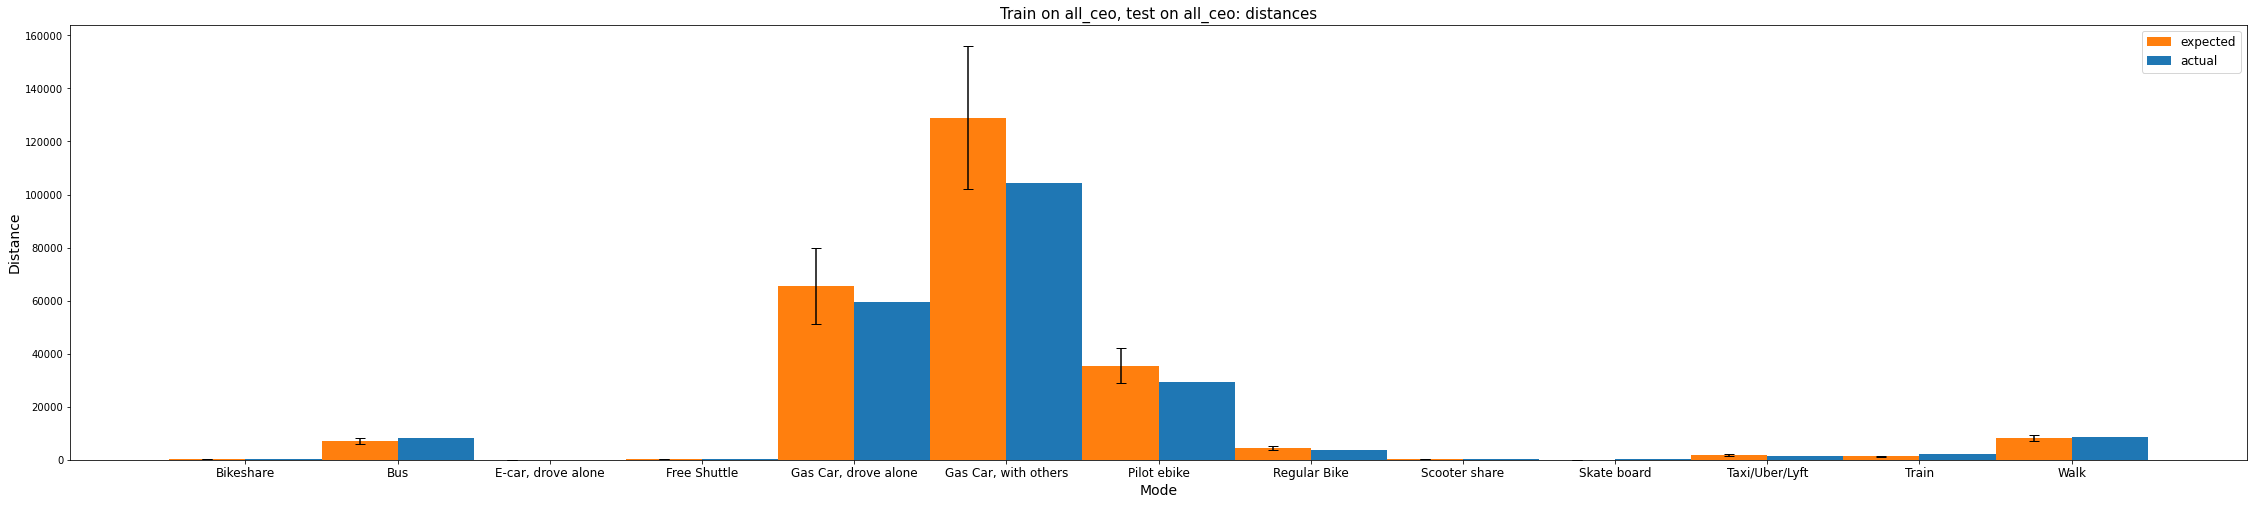

In [89]:
'''
Train on all_ceo, test on all_ceo: distances
'''
# get data
import pandas as pd
import numpy as np
import helper_functions as helper
import confusion_matrix_handling as cm_handling

df_EI = pd.read_csv(r'Public_Dashboard/auxiliary_files/energy_intensity.csv')
energy_dict = cm_handling.get_energy_dict(df_EI, units='MWH')
from confusion_matrix_handling import MODE_MAPPING_DICT

# get result from running store_expanded_labeled_trips.ipynb
%store -r expanded_labeled_trips 
expanded_labeled_trips = helper.get_primary_modes(expanded_labeled_trips[expanded_labeled_trips.section_modes.notna()], energy_dict, MODE_MAPPING_DICT)

# split in half.
from sklearn.utils import shuffle
shuffled_trips = shuffle(expanded_labeled_trips)
shuffled_trips = helper.drop_unwanted_trips(shuffled_trips, drop_not_a_trip=True)
samplingCM = shuffled_trips.iloc[0:int(len(expanded_labeled_trips.index)/2)]
testingCM = shuffled_trips.iloc[int(len(expanded_labeled_trips.index)/2):]

samplingCMiOS = samplingCM.loc[samplingCM['os'] == "ios"]
samplingCMandroid = samplingCM.loc[samplingCM['os'] == "android"]
testingCMiOS = testingCM.loc[testingCM['os'] == "ios"]
testingCMandroid = testingCM.loc[testingCM['os'] == "android"]

samplingCMiOS = pair_matching(samplingCMiOS, by_distances=True)
samplingCMandroid = pair_matching(samplingCMandroid, by_distances=True)
testingCMiOS = pair_matching(testingCMiOS, by_distances=True)
testingCMandroid = pair_matching(testingCMandroid, by_distances=True)

samplingCMiOS = map_labels(samplingCMiOS, MODE_MAPPING_DICT)
samplingCMandroid = map_labels(samplingCMandroid, MODE_MAPPING_DICT)
testingCMiOS = map_labels(testingCMiOS, MODE_MAPPING_DICT)
testingCMandroid = map_labels(testingCMandroid, MODE_MAPPING_DICT)

# convert from meters to miles
METERS_TO_MILES = 0.000621371 # 1 meter = 0.000621371 miles
samplingCMiOS = samplingCMiOS * METERS_TO_MILES
samplingCMandroid = samplingCMandroid * METERS_TO_MILES
testingCMiOS = testingCMiOS * METERS_TO_MILES
testingCMandroid = testingCMandroid * METERS_TO_MILES

testingCMiOS = fill_in([samplingCMiOS, samplingCMandroid, testingCMandroid], testingCMiOS)
testingCMandroid = fill_in([testingCMiOS], testingCMandroid)
samplingCMiOS = fill_in([testingCMiOS], samplingCMiOS)
samplingCMandroid = fill_in([testingCMiOS], samplingCMandroid)

samplingCMiOS = samplingCMiOS.sort_index()
samplingCMandroid = samplingCMandroid.sort_index()
testingCMiOS = testingCMiOS.sort_index()
testingCMandroid = testingCMandroid.sort_index()

android_predictions = testingCMandroid.sum(axis=0)
ios_predictions = testingCMiOS.sum(axis=0)

# finding distances
'''
iOS
'''
iosCMs = sampling(samplingCMiOS, n = 2000)
iosProbs = actual_given_sensed_CM(iosCMs)
iosEstimates = distance_estimate(ios_predictions, iosProbs, "ios")

'''
android
'''
androidCMs = sampling(samplingCMandroid, n = 2000)
androidProbs = actual_given_sensed_CM(androidCMs)
androidEstimates = distance_estimate(android_predictions, androidProbs, "android")

# combine results for ios and android distances just by adding
total_distance_estimates = androidEstimates[0] + iosEstimates[0]
total_variances = androidEstimates[1] + iosEstimates[1]

actual = (testingCMandroid.add(testingCMiOS)).sum(axis="columns").T
sd_from_actual = (total_distance_estimates.subtract(actual)).div(np.sqrt(total_variances))

print(pd.DataFrame({"estimates":total_distance_estimates, "actual":actual, "sd from actual": sd_from_actual}))
plot_results(total_distance_estimates, actual, np.sqrt(total_variances), "Distance", "Train on all_ceo, test on all_ceo: distances")

In [ ]:
# combine results for ios and android distances by a weighted sum
total_android_distance = testingCMandroid.sum().sum()
total_ios_distance = testingCMiOS.sum().sum()
ios_weight = total_ios_distance / (total_ios_distance + total_android_distance)
android_weight = 1 - ios_weight
print("ios weight: ", ios_weight, " android weight: ", android_weight, "\n")

total_weighted_estimates = (iosEstimates[0] * ios_weight).add(androidEstimates[0] * android_weight)
total_weighted_variance = (iosEstimates[1] * ios_weight).add(androidEstimates[1] * android_weight)
sd_from_actual = (total_weighted_estimates.subtract(actual)).div(np.sqrt(total_weighted_variance))

print(pd.DataFrame({"weighted estimate":total_weighted_estimates, "actual":actual, "sd from actual": sd_from_actual}))

# Train on All_CEO, test on All_CEO: counts

Dropped 93 trips with no sensed sections.
Dropping user labeled AIR trips and trips with no OS.
Also dropping trips labeled as not a trip and trips with mode_confirm of nan.
                      Actual      Estimated  sd from actual
Bikeshare               65.0    71.52638607      0.58928401
Bus                    697.0   701.64435697      0.13293114
E-car, drove alone       0.0     5.43068754      1.85489004
Free Shuttle            50.0    49.82333056     -0.01893996
Gas Car, drove alone  9151.0  9415.82757176      2.50701418
Gas Car, with others  9819.0  9604.15849612     -1.99919486
Pilot ebike           9897.0  9745.05093468     -1.47530935
Regular Bike          1326.0  1408.73497693      1.74871156
Scooter share           33.0    55.58043268      2.26878951
Skate board             20.0    19.79297987     -0.03547082
Taxi/Uber/Lyft         180.0   208.86469030      1.50258801
Train                   98.0    70.47727963     -2.82734750
Walk                  6753.0  6732.08787690   

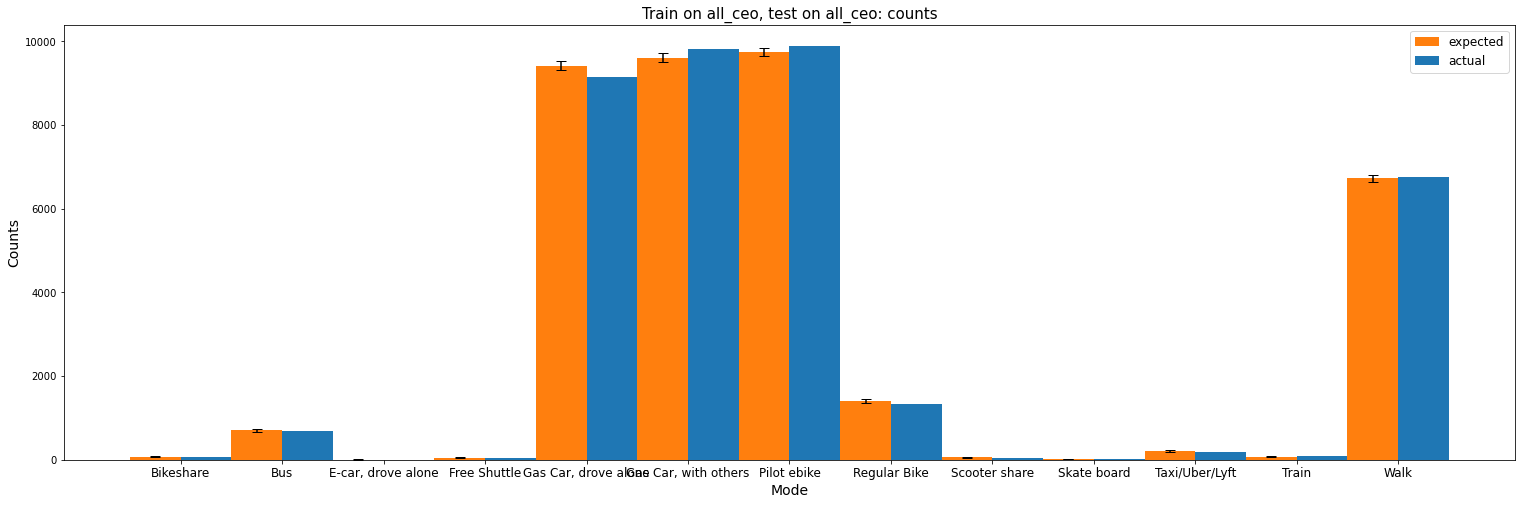

In [88]:
'''
Train on all_ceo, test on all_ceo: distances
'''
# get data
df_EI = pd.read_csv(r'Public_Dashboard/auxiliary_files/energy_intensity.csv')
energy_dict = cm_handling.get_energy_dict(df_EI, units='MWH')
from confusion_matrix_handling import MODE_MAPPING_DICT

# get result from running store_expanded_labeled_trips.ipynb
%store -r expanded_labeled_trips 
expanded_labeled_trips = helper.get_primary_modes(expanded_labeled_trips[expanded_labeled_trips.section_modes.notna()], energy_dict, MODE_MAPPING_DICT)

# split in half.
from sklearn.utils import shuffle
shuffled_trips = shuffle(expanded_labeled_trips)
shuffled_trips = helper.drop_unwanted_trips(shuffled_trips, drop_not_a_trip=True)
samplingCM = shuffled_trips.iloc[0:int(len(expanded_labeled_trips.index)/2)]
testingCM = shuffled_trips.iloc[int(len(expanded_labeled_trips.index)/2):]

# clean up
samplingCM = pair_matching(samplingCM, by_distances=False)
samplingCM = map_labels(samplingCM, MODE_MAPPING_DICT)

testingCM = pair_matching(testingCM, by_distances=False)
testingCM = map_labels(testingCM, MODE_MAPPING_DICT)

samplingCM = fill_in([testingCM], samplingCM)
testingCM = fill_in([samplingCM], testingCM)

# also removing the no_sensed and air_or_hsr sensed labels since they don't have a corresp match in the standardized user labels
samplingCM = samplingCM.drop(labels=["air_or_hsr", "no_sensed"], axis=1)
testingCM = testingCM.drop(labels=["air_or_hsr", "no_sensed"], axis=1)

# making rows and columns the same order
testingCM = testingCM.loc[:, samplingCM.columns]
testingCM = testingCM.sort_index()
samplingCM = samplingCM.sort_index()

# print(samplingCM)
# print(testingCM)

validation_data = testingCM.sum(axis=0)

# finding counts
countSamples = sampling(samplingCM, 2000)
countProbs = actual_given_sensed_CM(countSamples)
countEstimates = count_estimate(validation_data, countProbs)

sd_from_actual = (countEstimates[0].subtract(testingCM.sum(axis=1).T)).div(np.sqrt(countEstimates[1]))

print(pd.DataFrame({"Actual":testingCM.sum(axis=1).T, "Estimated":countEstimates[0], "sd from actual":sd_from_actual}))
plot_results(countEstimates[0], testingCM.sum(axis=1).T, np.sqrt(countEstimates[1]), "Counts", "Train on all_ceo, test on all_ceo: counts")

# Train on MobilityNet, test on All_CEO: distances

In [30]:
def update_probabilities(cm, prior_mode_probs):
    p_predicted_given_actual = cm.div(cm.sum(axis=1), axis='rows')
    likelihood_times_priors = p_predicted_given_actual.multiply(pd.Series(prior_mode_probs), axis='rows')
    normalizing_constants = likelihood_times_priors.sum(axis='rows')
    prob_actual_given_predicted_df = likelihood_times_priors.divide(normalizing_constants, axis='columns').copy()

    return prob_actual_given_predicted_df

In [81]:
'''
Train on MobilityNet, test on all_ceo: distances
'''
# get data
import pandas as pd
import confusion_matrix_handling as cm_handling
from confusion_matrix_handling import MODE_MAPPING_DICT
import helper_functions as helper
df_EI = pd.read_csv(r'Public_Dashboard/auxiliary_files/energy_intensity.csv')
energy_dict = cm_handling.get_energy_dict(df_EI, units='MWH')

pd.set_option("display.precision", 8)
# csv files were generated in classification_analysis.ipynb from the MobilityNet repo
training_android = pd.read_csv("MobilityNetCMs/mobilitynet_android.csv", index_col=0).T
training_ios = pd.read_csv("MobilityNetCMs/mobilitynet_ios.csv", index_col=0).T

# remove all no_gt and no_sensed
training_android = cm_handling.drop_rows_and_columns(training_android, row_list=["NO_GT_START", "NO_GT_MIDDLE", "NO_GT_END"], column_list=["NO_SENSED_START", "NO_SENSED_MIDDLE", "NO_SENSED_END"])
training_ios =cm_handling.drop_rows_and_columns(training_ios, row_list=["NO_GT_START", "NO_GT_MIDDLE", "NO_GT_END"], column_list=["NO_SENSED_START", "NO_SENSED_MIDDLE", "NO_SENSED_END", "UNKNOWN"])

# get all_ceo data by OS
%store -r expanded_labeled_trips 
expanded_labeled_trips = helper.get_primary_modes(expanded_labeled_trips[expanded_labeled_trips.section_modes.notna()], energy_dict, MODE_MAPPING_DICT)

from sklearn.utils import shuffle
shuffled_trips = shuffle(expanded_labeled_trips)
shuffled_trips = helper.drop_unwanted_trips(shuffled_trips, drop_not_a_trip=True)

testing_android = shuffled_trips.loc[shuffled_trips['os'] == "android"]
testing_ios = shuffled_trips.loc[shuffled_trips['os'] == "ios"]

# make all_ceo trips into CMs
testing_android = pair_matching(testing_android, by_distances=True)
testing_ios = pair_matching(testing_ios, by_distances=True)

from confusion_matrix_handling import MODE_MAPPING_DICT

testing_android = map_labels(testing_android, MODE_MAPPING_DICT)
testing_ios = map_labels(testing_ios, MODE_MAPPING_DICT)

# make all_ceo CMs look like MobilityNet
all_ceo_to_MN_label_map = {
    "Regular Bike": "Bicycling",
    "Bikeshare": "Bicycling",
    "Gas Car, drove alone": "Car",
    "Gas Car, with others": "Car",
    "Taxi/Uber/Lyft": "Car",
    "Pilot ebike": "E_bike",
    "Scooter share": "Escooter",
    "Walk":"Walking"
}

testing_android = map_labels(testing_android, all_ceo_to_MN_label_map, remove_unknown=False)
testing_ios = map_labels(testing_ios, all_ceo_to_MN_label_map, remove_unknown=False)

# print(testing_android)
# print(training_android)
# print(testing_ios)
# print(training_ios)

testing_android = cm_handling.drop_rows_and_columns(testing_android, row_list=["Skate board", "Free Shuttle"], column_list=[])
testing_ios = cm_handling.drop_rows_and_columns(testing_ios, row_list=["Skate board", "Free Shuttle", "E-car, drove alone"], column_list=[])
training_android = cm_handling.drop_rows_and_columns(training_android, row_list=["LIGHT_RAIL", "SUBWAY"], column_list=[])
training_ios = cm_handling.drop_rows_and_columns(training_ios, row_list=["LIGHT_RAIL", "SUBWAY"], column_list=[])

# MN has labels in all caps....
testing_android.columns = map(lambda x: str(x).upper(), testing_android.columns)
testing_android.index = map(lambda x: str(x).upper(), testing_android.index)
testing_ios.columns = map(lambda x: str(x).upper(), testing_ios.columns)
testing_ios.index = map(lambda x: str(x).upper(), testing_ios.index)

testing_android = cm_handling.drop_rows_and_columns(testing_android, row_list=[], column_list=["NO_SENSED"])
testing_ios = cm_handling.drop_rows_and_columns(testing_ios, row_list=[], column_list=["NO_SENSED"])

# make sure all CMs have the same columns and rows
training_android = fill_in([training_ios, testing_android, testing_ios], training_android)
training_ios = fill_in([training_android], training_ios)
testing_android = fill_in([training_android], testing_android)
testing_ios = fill_in([training_android], testing_ios)

# put all CM indexes into the same order
training_ios = training_ios.sort_index()
training_android = training_android.sort_index()
testing_ios = testing_ios.sort_index()
testing_android = testing_android.sort_index()

Dropped 93 trips with no sensed sections.
Dropping user labeled AIR trips and trips with no OS.
Also dropping trips labeled as not a trip and trips with mode_confirm of nan.



Combined results: 
                 estimates          actual  sd from actual
BICYCLING  1.24560796e+07  1.31373718e+07     -0.21370876
BUS        1.40360075e+07  2.32711131e+07     -4.27534397
CAR        6.65447645e+08  5.48577785e+08      0.77468149
ESCOOTER   4.77742281e+05  4.74010691e+05      0.04325396
E_BIKE     8.74644089e+07  9.75801376e+07     -0.72698478
TRAIN      3.55703105e+06  6.32587770e+06     -4.63497937
WALKING    4.95817099e+07  2.60725491e+07      2.44169399


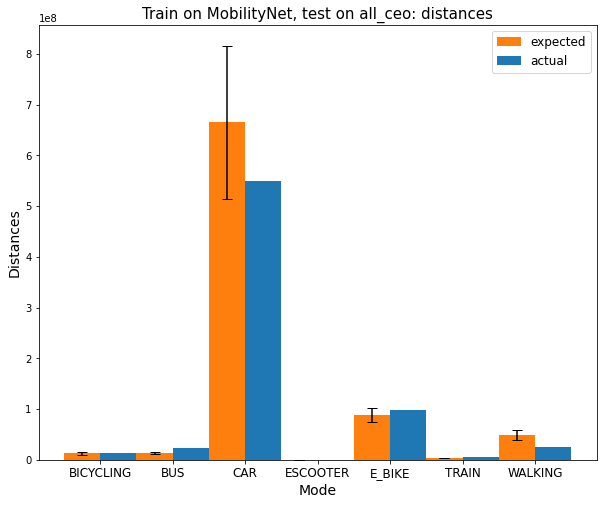

In [82]:
'''
Do the thing
'''
# find priors of testing set
total_testing = testing_android.add(testing_ios)
priors = total_testing.sum(axis=1) / total_testing.sum().sum()

android_predictions = testing_android.sum(axis=0)
ios_predictions = testing_ios.sum(axis=0)

android_samples = sampling(training_android, 2000)
android_probabilities = [] 
for cm in android_samples:
    android_probabilities.append(update_probabilities(cm, priors))
android_distance_estimates = distance_estimate(android_predictions, android_probabilities, 'android')

ios_samples = sampling(training_ios, 2000)
ios_probabilities = []
for cm in ios_samples:
    ios_probabilities.append(update_probabilities(cm, priors))
ios_distance_estimates = distance_estimate(ios_predictions, ios_probabilities, 'ios')

# combine results for ios and android distances by addition
total_distance = android_distance_estimates[0] + ios_distance_estimates[0]
total_variances = android_distance_estimates[1] + ios_distance_estimates[1]

actual = (testing_android.add(testing_ios)).sum(axis = "columns").T
sd_from_actual = (total_distance.subtract(actual)).div(np.sqrt(total_variances))

print("\nCombined results: \n", pd.DataFrame({"estimates":total_distance, "actual":actual, "sd from actual": sd_from_actual}))
plot_results(total_distance, actual, np.sqrt(total_variances), "Distances", "Train on MobilityNet, test on all_ceo: distances")

# Train on MobilityNet, test on All_CEO: counts
This uses Mobilitynet duration CM

In [79]:
'''
Train on MobilityNet, test on all_ceo: counts
'''
# get data
import pandas as pd
import confusion_matrix_handling as cm_handling
from confusion_matrix_handling import MODE_MAPPING_DICT
import helper_functions as helper
df_EI = pd.read_csv(r'Public_Dashboard/auxiliary_files/energy_intensity.csv')
energy_dict = cm_handling.get_energy_dict(df_EI, units='MWH')

pd.set_option("display.precision", 8)
# csv files were generated in classification_analysis.ipynb from the MobilityNet repo
training_android = pd.read_csv("MobilityNetCMs/mobilitynet_duration_android.csv", index_col=0).T
training_ios = pd.read_csv("MobilityNetCMs/mobilitynet_duration_ios.csv", index_col=0).T

trainingCM = training_ios.add(training_android)

# remove all no_gt and no_sensed
trainingCM = cm_handling.drop_rows_and_columns(trainingCM, row_list=["NO_GT_START", "NO_GT_MIDDLE", "NO_GT_END"], column_list=["NO_SENSED_START", "NO_SENSED_MIDDLE", "NO_SENSED_END", "UNKNOWN"])

# get all_ceo data by OS
%store -r expanded_labeled_trips 
expanded_labeled_trips = helper.get_primary_modes(expanded_labeled_trips[expanded_labeled_trips.section_modes.notna()], energy_dict, MODE_MAPPING_DICT)

# make all_ceo trips into CMs
testingCM = pair_matching(expanded_labeled_trips, by_distances=False)

from confusion_matrix_handling import MODE_MAPPING_DICT

testingCM = map_labels(testingCM, MODE_MAPPING_DICT)

# make all_ceo CMs look like MobilityNet
all_ceo_to_MN_label_map = {
    "Regular Bike": "Bicycling",
    "Bikeshare": "Bicycling",
    "Gas Car, drove alone": "Car",
    "Gas Car, with others": "Car",
    "Taxi/Uber/Lyft": "Car",
    "Pilot ebike": "E_bike",
    "Scooter share": "Escooter",
    "Walk":"Walking"
}

testingCM = map_labels(testingCM, all_ceo_to_MN_label_map, remove_unknown=False)

# print(trainingCM)
# print(testingCM)

testingCM = cm_handling.drop_rows_and_columns(testingCM, row_list=["Skate board", "Free Shuttle", "E-car, drove alone", "Not a Trip", "Air"], column_list=["air_or_hsr"])
trainingCM = cm_handling.drop_rows_and_columns(trainingCM, row_list=["LIGHT_RAIL", "SUBWAY"], column_list=["LIGHT_RAIL", "AIR_OR_HSR"])

# MN has labels in all caps....
testingCM.columns = map(lambda x: str(x).upper(), testingCM.columns)
testingCM.index = map(lambda x: str(x).upper(), testingCM.index)

testingCM = cm_handling.drop_rows_and_columns(testingCM, row_list=[], column_list=["NO_SENSED"])

# make sure all CMs have the same columns and rows
testingCM = fill_in([trainingCM], testingCM)
trainingCM = fill_in([testingCM], trainingCM)

# put all CM indexes into the same order
testingCM = testingCM.sort_index()
trainingCM = trainingCM.sort_index()

# print("*********")
# print(trainingCM)
# print(testingCM)

Dropped 93 trips with no sensed sections.
            AIR_OR_HSR       BICYCLING              BUS             CAR  \
WALKING            NaN   6116.37996078    6942.44254065   3963.39703345   
CAR                NaN   3843.80235291      43.04799509  45190.02854609   
BICYCLING          NaN  23241.45599818       0.00000000      0.00000000   
ESCOOTER           NaN  26443.25724816      38.75387979    537.70662713   
BUS                NaN    297.14035583  110197.78388906  35356.73733974   
TRAIN              NaN    132.23306155    1466.01585603  30385.70853806   
SUBWAY             NaN      0.00000000     262.13885713   1994.53732705   
E_BIKE             NaN  36493.68875670       0.00000000      0.00000000   
LIGHT_RAIL         NaN   1525.70011544   20064.75608110   1410.94562006   

            LIGHT_RAIL           SUBWAY            TRAIN          WALKING  
WALKING            NaN    1397.75611758    2566.10485816  136562.14844394  
CAR                NaN       0.00000000       0.0000000


Combined results: 
                 estimates   actual  sd from actual
BICYCLING   1595.07573596   3031.0    -74.44669904
BUS          765.11256858   1478.0     -5.76224211
CAR        42777.90461305  40606.0     14.00143531
ESCOOTER      56.44462712     90.0    -46.36309144
E_BIKE     12928.84996758  20773.0    -87.12315769
TRAIN         73.83114625    185.0   -104.43429796
WALKING    22252.78134146  14287.0     70.06305632


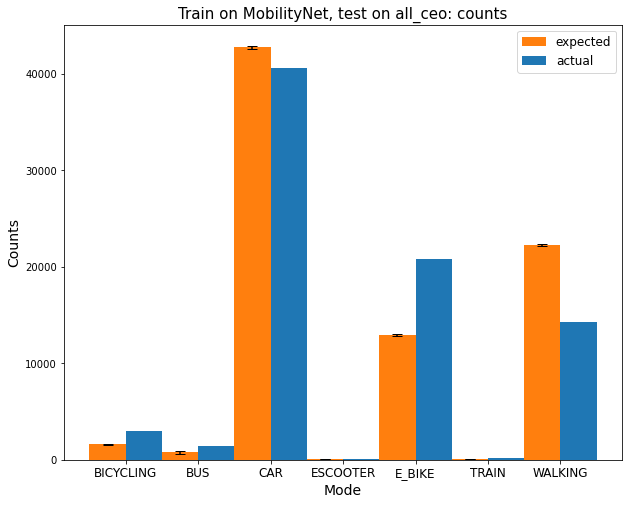

In [80]:
'''
Do the thing
'''
# find priors of testing set
priors = testingCM.sum(axis=1) / testingCM.sum().sum()

predictions = testingCM.sum(axis=0)

samples = sampling(trainingCM, 2000)
probabilities = []
for cm in samples:
    probabilities.append(update_probabilities(cm, priors))
count_estimates = count_estimate(predictions, probabilities)

actual = (testingCM).sum(axis = 1).T
sd_from_actual = (count_estimates[0].subtract(actual)).div(np.sqrt(count_estimates[1]))

print("\nCombined results: \n", pd.DataFrame({"estimates":count_estimates[0], "actual":actual, "sd from actual": sd_from_actual}))
plot_results(count_estimates[0], actual, np.sqrt(count_estimates[1]), "Counts", "Train on MobilityNet, test on all_ceo: counts")